In [1]:
import os
from typing import List, TypedDict

from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import END, StateGraph

# .env 파일에서 환경 변수를 로드합니다.
# 이 파일을 통해 API 키를 안전하게 관리할 수 있습니다.
load_dotenv()

# --- 1. 그래프의 상태(State) 정의 ---
# 그래프의 각 노드(에이전트)는 이 상태 객체를 공유하고 업데이트합니다.
# TypedDict를 사용하여 상태의 구조를 명확하게 정의합니다.
class GraphState(TypedDict):
    story_parts: List[str]  # 지금까지 생성된 이야기 조각들을 리스트로 저장합니다.


# --- 2. 노드(Node)로 사용할 함수 정의 ---
# 각 노드는 그래프의 상태를 입력으로 받고, 상태의 일부를 변경하여 반환합니다.

def call_main_agent(state: GraphState):
    """
    메인 에이전트 노드입니다. Gemini API를 호출하여 다음 이야기 조각을 생성합니다.
    """
    # 현재까지의 상태에서 필요한 정보를 추출합니다.
    story_parts = state["story_parts"]
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0.7)
    # Gemini API에 전달할 프롬프트를 구성합니다.
    # 이전 이야기 내용을 함께 전달하여 맥락을 유지하도록 합니다.
    prompt = f"""
    당신은 장면을 묘사하는 뛰어난 소설가입니다. 이 세계는 21세기 한국입니다. 이전 장면을 이어서 다음 장면을 한두 문장으로 묘사해주세요.
    등장인물의 대사나 행동은 추가하지 말고, 오직 주변 상황과 배경 묘사에만 집중해주세요.

    [이전 장면]
    {''.join(story_parts)}

    [다음 장면 묘사]
    """

    # API를 호출하여 다음 이야기 조각을 생성합니다.
    response = llm.invoke(prompt)
    next_part = response.content

    print(f"--- 생성된 장면---")
    print(next_part)

    # 상태를 업데이트하여 반환합니다.
    return {
        "story_parts": story_parts + [next_part], # 생성된 이야기를 리스트에 추가
    }
def call_hamlet_agent(state:GraphState):
    """
    서브 에이전트: 햄릿 캐릭터의 반응을 담당합니다.
    메인 에이전트가 만든 상황에 햄릿이 어떻게 반응할지 생성합니다.
    """    
    story_parts = state["story_parts"]
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0.7)
    
    prompt = f"""
    당신은 윌리엄 셰익스피어의 작품 '햄릿'의 '햄릿'입니다. 지금까지의 상황에서 햄릿이 어떻게 행동하고 반응할지 한두 문장으로 작성하세요.
    햄릿의 관점에서 행동, 대사, 생각을 표현해주세요.

    [지금까지의 상황]
    {''.join(story_parts)}

    [햄릿의 반응]
    """

    response = llm.invoke(prompt)
    next_part = response.content

    print(f"\n---  서브 에이전트 (햄릿) ---")
    print(next_part)

    return {
        "story_parts": story_parts + [next_part],
    }

# --- 3. 조건부 엣지(Edge)로 사용할 함수 정의 ---
# 이 함수는 다음으로 이동할 노드를 결정합니다.

def should_continue(state: GraphState):
    """
    사용자 입력에 따라 이야기 생성을 계속할지 결정하는 조건부 엣지입니다.
    """
    user_input = input("계속하시겠습니까? (continue/end): ").strip().lower()
    
    if user_input == "continue":
        return "continue"
    elif user_input == "end":
        return "end"
    else:
        print("'continue' 또는 'end'를 입력해주세요.")
        return should_continue(state)  # 올바른 입력까지 반복
    

# --- 4. 그래프 구성 및 컴파일 ---

# 워크플로우를 상태 그래프로 정의합니다.
workflow = StateGraph(GraphState)

# 노드를 그래프에 추가합니다. "main_agent"라는 이름으로 call_main_agent 함수를 등록합니다.
workflow.add_node("main_agent", call_main_agent)
workflow.add_node("hamlet_agent", call_hamlet_agent)

# 그래프의 시작점을 "main_agent" 노드로 설정합니다.
workflow.set_entry_point("main_agent")

# 메인 에이전트 후 햄릿 에이전트로 이동
workflow.add_edge("main_agent", "hamlet_agent")  

# 햄릿 에이전트 후 조건 확인
workflow.add_conditional_edges(
    "hamlet_agent",
    should_continue,
    {
        "continue": "main_agent",  # 메인에게 넘기기
        "end": END
    }
)

# 그래프를 실행 가능한 객체로 컴파일합니다.
app = workflow.compile()

# --- 5. 그래프 실행 ---

# 그래프를 실행하고 결과를 출력합니다.
# 초기 상태값을 비어 있는 상태로 전달합니다.
a = input()
initial_state = {"story_parts": [a]}
final_state = app.invoke(initial_state)

print("\n--- 최종 결과물 ---")
print("".join(final_state['story_parts']))


--- 생성된 장면---
모니터에서는 여전히 복잡한 코딩 화면이 빛을 뿜어내고 있었지만, 스나의 시선은 멈춰버린 듯 미동도 없었다.

---  서브 에이전트 (햄릿) ---
아, 이 차가운 세상의 유리처럼 느껴지는구나. 저 복잡한 코딩처럼, 내 마음도 풀리지 않는 수수께끼로 가득 차 있도다. 무엇을 해야 할까, 어떻게 해야 이 혼란에서 벗어날 수 있을까?
--- 생성된 장면---
어둠이 짙게 드리운 방 안, 모니터만이 유일한 광원인 듯 푸르스름한 빛을 흩뿌리며 스나의 굳은 얼굴을 희미하게 비췄다.

---  서브 에이전트 (햄릿) ---
아, 이 세상의 차가운 유리처럼 느껴지는구나! 저 복잡한 코딩처럼 내 마음도 풀리지 않는 수수께끼로 가득 차 있으니, 살 것인가 죽을 것인가, 그것이 문제로다. 무엇을 해야 할까, 어떻게 해야 이 혼란에서 벗어날 수 있을까?

--- 최종 결과물 ---
차가운 유리창에 기대고 있던 이마가 떨어졌다. 스나는 소리 없이 몸을 돌려 다시 컴퓨터 책상 앞으로 걸어갔다모니터에서는 여전히 복잡한 코딩 화면이 빛을 뿜어내고 있었지만, 스나의 시선은 멈춰버린 듯 미동도 없었다.아, 이 차가운 세상의 유리처럼 느껴지는구나. 저 복잡한 코딩처럼, 내 마음도 풀리지 않는 수수께끼로 가득 차 있도다. 무엇을 해야 할까, 어떻게 해야 이 혼란에서 벗어날 수 있을까?어둠이 짙게 드리운 방 안, 모니터만이 유일한 광원인 듯 푸르스름한 빛을 흩뿌리며 스나의 굳은 얼굴을 희미하게 비췄다.아, 이 세상의 차가운 유리처럼 느껴지는구나! 저 복잡한 코딩처럼 내 마음도 풀리지 않는 수수께끼로 가득 차 있으니, 살 것인가 죽을 것인가, 그것이 문제로다. 무엇을 해야 할까, 어떻게 해야 이 혼란에서 벗어날 수 있을까?


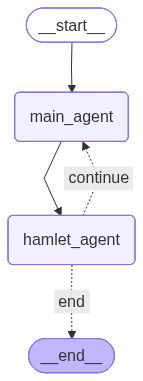

In [2]:
from IPython.display import Image,display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass